<a href="https://colab.research.google.com/github/Heterotic-Research/sns-phc-303/blob/main/PhaseSpacePlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saved example plots: phase_lotka_volterra.png, phase_fitzhugh_nagumo.png


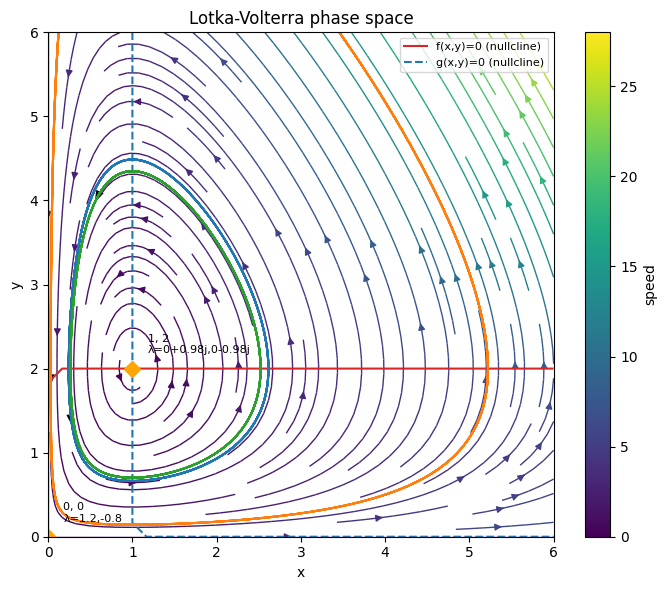

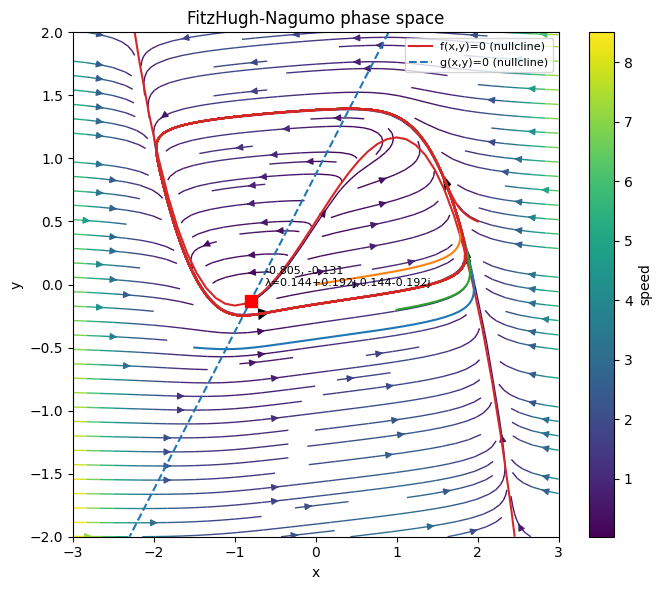

In [ ]:
#!/usr/bin/env python3
"""
phase_space.py

General utilities to plot phase space for 2-variable ODE systems:

  dx/dt = f(x, y)
  dy/dt = g(x, y)

Features:
- vector field (streamplot or quiver)
- nullclines (f=0 and g=0)
- numerical trajectories from multiple initial conditions (solve_ivp)
- automatic search for fixed points and stability classification (Jacobian & eigenvalues)
- examples: Lotka-Volterra and FitzHugh-Nagumo

Usage:
  python phase_space.py        # runs example plots
  or import plot_phase_space, find_fixed_points from this module

Dependencies:
  numpy, matplotlib, scipy

Author: Copied-style example for demonstration
"""
from typing import Callable, Iterable, List, Tuple, Optional
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root
import warnings

VectorField = Callable[[np.ndarray, np.ndarray], Tuple[np.ndarray, np.ndarray]]
# Alternatively a function f(t, u) that returns [dx, dy] can be wrapped easily


def _wrap_vector_field(func: Callable[[float, np.ndarray], np.ndarray]):
    """Return a function f(x,y) -> (fx,fy) from signature f(t, [x,y])."""
    def wrapper(X, Y):
        pts = np.vstack([X.ravel(), Y.ravel()])  # shape (2, N)
        out = np.empty_like(pts)
        for i in range(pts.shape[1]):
            uv = func(0.0, pts[:, i])
            out[:, i] = uv
        fx = out[0, :].reshape(X.shape)
        fy = out[1, :].reshape(X.shape)
        return fx, fy
    return wrapper


def jacobian_2d(func: Callable[[np.ndarray], np.ndarray], point: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    """Numerical Jacobian of a 2D vector-valued function: func([x,y]) -> [f,g]."""
    x0 = np.asarray(point, dtype=float)
    J = np.zeros((2, 2), dtype=float)
    f0 = np.asarray(func(x0))
    for i in range(2):
        dx = np.zeros_like(x0)
        dx[i] = eps
        fi = np.asarray(func(x0 + dx))
        J[:, i] = (fi - f0) / eps
    return J


def find_fixed_points(func: Callable[[np.ndarray], np.ndarray],
                      xlim: Tuple[float, float],
                      ylim: Tuple[float, float],
                      grid: int = 8,
                      tol: float = 1e-6) -> List[np.ndarray]:
    """
    Search for roots of func([x,y]) = 0 using multiple starting guesses on a grid.
    Returns a list of unique fixed points (as np.arrays).
    """
    xs = np.linspace(xlim[0], xlim[1], grid)
    ys = np.linspace(ylim[0], ylim[1], grid)
    found = []
    for xi in xs:
        for yi in ys:
            guess = np.array([xi, yi], dtype=float)
            try:
                sol = root(lambda z: func(z), guess, tol=1e-8)
                if sol.success:
                    pt = np.round(sol.x, decimals=8)
                    # check duplicates
                    if not any(np.linalg.norm(pt - f) < tol for f in found):
                        # ensure point is inside bounds (tolerant)
                        if (xlim[0] - 1e-6 <= pt[0] <= xlim[1] + 1e-6) and (ylim[0] - 1e-6 <= pt[1] <= ylim[1] + 1e-6):
                            found.append(pt)
            except Exception:
                continue
    return found


def plot_phase_space(vector_field: Callable[[np.ndarray], np.ndarray],
                     xlim: Tuple[float, float] = (-5, 5),
                     ylim: Tuple[float, float] = (-5, 5),
                     density: int = 25,
                     trajectories: Optional[Iterable[Tuple[float, float]]] = None,
                     t_span: Tuple[float, float] = (0, 50),
                     t_eval: Optional[np.ndarray] = None,
                     figsize: Tuple[int, int] = (7, 6),
                     arrowstyle: str = "stream",  # "stream" or "quiver"
                     plot_nullclines: bool = True,
                     show_fixed_points: bool = True,
                     title: Optional[str] = None,
                     ax: Optional[plt.Axes] = None):
    """
    Plot phase space for a 2D system. `vector_field` must be a function that takes a 2-array [x,y]
    and returns a 2-array [dx,dy]. If you have a function f(t, u) use a small wrapper:
      vf = lambda z: f(0, z)

    Parameters:
      - xlim, ylim: plotting ranges
      - density: number of vectors per axis for the vector field
      - trajectories: iterable of (x0, y0) initial conditions for trajectories
      - t_span, t_eval: time interval and sample times for trajectories (passed to solve_ivp)
      - arrowstyle: "stream" uses streamplot, "quiver" uses quiver
      - plot_nullclines: draw f=0 and g=0 contours
      - show_fixed_points: numerically search and annotate fixed points
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    xmin, xmax = xlim
    ymin, ymax = ylim

    nx = density
    ny = density
    x = np.linspace(xmin, xmax, nx)
    y = np.linspace(ymin, ymax, ny)
    X, Y = np.meshgrid(x, y)

    # Evaluate vector field on grid
    FX = np.zeros_like(X)
    FY = np.zeros_like(Y)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            v = vector_field(np.array([X[i, j], Y[i, j]]))
            FX[i, j] = v[0]
            FY[i, j] = v[1]

    # Normalize for plotting arrows
    speed = np.sqrt(FX**2 + FY**2)
    max_speed = np.nanmax(speed)
    if max_speed == 0:
        max_speed = 1.0

    # Vector field
    if arrowstyle == "stream":
        strm = ax.streamplot(X, Y, FX, FY, color=speed, cmap='viridis', linewidth=1, density=1.2)
        fig.colorbar(strm.lines, ax=ax, label='speed')
    else:
        ax.quiver(X, Y, FX / max_speed, FY / max_speed, speed, cmap='viridis')

    # Nullclines
    if plot_nullclines:
        # compute scalar fields f(x,y) and g(x,y) on a finer grid for contouring
        xf = np.linspace(xmin, xmax, int(1.5 * nx))
        yf = np.linspace(ymin, ymax, int(1.5 * ny))
        XF, YF = np.meshgrid(xf, yf)
        FF = np.zeros_like(XF)
        GG = np.zeros_like(YF)
        for i in range(XF.shape[0]):
            for j in range(XF.shape[1]):
                v = vector_field(np.array([XF[i, j], YF[i, j]]))
                FF[i, j] = v[0]
                GG[i, j] = v[1]
        # contour at zero
        try:
            ax.contour(XF, YF, FF, levels=[0], colors=['tab:red'], linewidths=1.5, linestyles='-')
            ax.contour(XF, YF, GG, levels=[0], colors=['tab:blue'], linewidths=1.5, linestyles='--')
            ax.plot([], [], color='tab:red', label='f(x,y)=0 (nullcline)')
            ax.plot([], [], color='tab:blue', linestyle='--', label='g(x,y)=0 (nullcline)')
        except Exception as e:
            warnings.warn(f"Could not draw nullclines: {e}")

    # Trajectories
    if trajectories:
        for x0, y0 in trajectories:
            def rhs(t, u):
                return vector_field(u)
            if t_eval is None:
                t_eval_local = np.linspace(t_span[0], t_span[1], 2000)
            else:
                t_eval_local = t_eval
            sol = solve_ivp(rhs, t_span, [x0, y0], t_eval=t_eval_local, rtol=1e-8, atol=1e-8, max_step=(t_span[1]-t_span[0])/100.0)
            ax.plot(sol.y[0], sol.y[1], lw=1.5)
            # plot arrow for direction at end
            if sol.y.shape[1] >= 2:
                ax.arrow(sol.y[0][-2], sol.y[1][-2],
                         sol.y[0][-1] - sol.y[0][-2],
                         sol.y[1][-1] - sol.y[1][-2],
                         shape='full', lw=0, length_includes_head=True, head_width=0.08*(xmax-xmin)/5, color='k')

    # Fixed points
    if show_fixed_points:
        def f_for_root(z):
            return vector_field(z)
        fps = find_fixed_points(f_for_root, xlim, ylim, grid=9, tol=1e-6)
        for fp in fps:
            J = jacobian_2d(lambda z: vector_field(z), fp)
            eigs = np.linalg.eigvals(J)
            # classify roughly
            if np.all(np.real(eigs) < 0):
                color = 'green'
                marker = 'o'
            elif np.all(np.real(eigs) > 0):
                color = 'red'
                marker = 's'
            else:
                color = 'orange'
                marker = 'D'
            ax.plot(fp[0], fp[1], marker=marker, color=color, markersize=8)
            ax.text(fp[0] + 0.03*(xmax-xmin), fp[1] + 0.03*(ymax-ymin),
                    f"{fp[0]:.3g}, {fp[1]:.3g}\nλ={eigs[0]:.3g},{eigs[1]:.3g}",
                    fontsize=8)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if title:
        ax.set_title(title)
    ax.grid(False)
    ax.legend(loc='upper right', fontsize=8)
    return fig, ax


# -------------------------
# Example models
# -------------------------
def lotka_volterra(alpha=1.0, beta=0.1, delta=0.1, gamma=1.0):
    def vf(u):
        x, y = u
        dx = alpha * x - beta * x * y
        dy = delta * x * y - gamma * y
        return np.array([dx, dy])
    return vf


def fitzhugh_nagumo(a=0.7, b=0.8, tau=12.5, I=0.5):
    # Standard form (v,w):
    # dv/dt = v - v^3/3 - w + I
    # dw/dt = (v + a - b*w)/tau
    def vf(u):
        v, w = u
        dv = v - (v**3)/3 - w + I
        dw = (v + a - b*w)/tau
        return np.array([dv, dw])
    return vf


# -------------------------
# If run as script, show examples
# -------------------------
if __name__ == "__main__":
    # Example 1: Lotka-Volterra
    lv = lotka_volterra(alpha=1.2, beta=0.6, delta=0.8, gamma=0.8)
    fig1, ax1 = plot_phase_space(lv,
                                xlim=(0, 6),
                                ylim=(0, 6),
                                density=25,
                                trajectories=[(0.5, 4.0), (4.0, 0.5), (2.0, 1.0), (1.0, 2.0)],
                                t_span=(0, 30),
                                arrowstyle="stream",
                                title="Lotka-Volterra phase space")
    fig1.tight_layout()
    fig1.savefig("phase_lotka_volterra.png", dpi=200)

    # Example 2: FitzHugh-Nagumo
    fn = fitzhugh_nagumo(a=0.7, b=0.8, tau=12.5, I=0.5)
    fig2, ax2 = plot_phase_space(fn,
                                xlim=(-3, 3),
                                ylim=(-2, 2),
                                density=35,
                                trajectories=[(-1.5, -0.5), (0.0, 0.0), (1.0, -0.2), (2.0, 0.5)],
                                t_span=(0, 200),
                                arrowstyle="stream",
                                title="FitzHugh-Nagumo phase space")
    fig2.tight_layout()
    fig2.savefig("phase_fitzhugh_nagumo.png", dpi=200)

    print("Saved example plots: phase_lotka_volterra.png, phase_fitzhugh_nagumo.png")